In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

2025-11-27 19:26:51.408681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 19:26:51.443425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 19:26:52.207383: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# ============================================================================
# SETUP: DIRETÓRIO E PASTAS
# ============================================================================

# Se estiver em notebooks/, suba para raiz
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    print(f"Mudando para: {os.getcwd()}")

# Criar pastas
Path('outputs/plots').mkdir(parents=True, exist_ok=True)
Path('outputs/reports').mkdir(parents=True, exist_ok=True)
Path('outputs/models').mkdir(parents=True, exist_ok=True)
Path('data/processed').mkdir(parents=True, exist_ok=True)

print(f"Working directory: {os.getcwd()}\n")

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

# GPU (opcional)
print("TensorFlow version:", tf.__version__)
print("GPU disponível:", len(tf.config.list_physical_devices('GPU')) > 0)


Mudando para: /home/maricarminate/Projetos/anomaly-detector
Working directory: /home/maricarminate/Projetos/anomaly-detector

TensorFlow version: 2.20.0
GPU disponível: False


2025-11-27 19:26:52.368475: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-11-27 19:26:52.368498: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-27 19:26:52.368501: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: maricarminate-MS-7E02
2025-11-27 19:26:52.368503: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: maricarminate-MS-7E02
2025-11-27 19:26:52.368596: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: 580.105.8
2025-11-27 19:26:52.368609: I external/local_xla/

In [3]:
# ============================================================================
# CARREGAR DADOS
# ============================================================================

print("=" * 70)
print("DIA 4: AUTOENCODER PARA DETECÇÃO DE ANOMALIAS")
print("=" * 70)

train = pd.read_csv('data/processed/nyc_taxi_train.csv', parse_dates=['timestamp'])
test = pd.read_csv('data/processed/nyc_taxi_test.csv', parse_dates=['timestamp'])

print(f"\nDados carregados:")
print(f"  Treino: {len(train)} pontos")
print(f"  Teste: {len(test)} pontos")

DIA 4: AUTOENCODER PARA DETECÇÃO DE ANOMALIAS

Dados carregados:
  Treino: 3494 pontos
  Teste: 874 pontos


In [4]:
# ============================================================================
# PREPARAR DADOS: SLIDING WINDOW
# ============================================================================

def create_sequences(data, seq_length=24):
    """
    Cria sequências de comprimento seq_length.
    
    Input: série temporal de valores
    Output: array 3D (num_sequences, seq_length, 1)
    """
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

print("\nPrepando dados com sliding window (24 horas)...")

seq_length = 24

# Extrair valores
train_values = train['value'].values.reshape(-1, 1)
test_values = test['value'].values.reshape(-1, 1)

# Normalizar (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Criar sequências
X_train = create_sequences(train_scaled, seq_length)
X_test = create_sequences(test_scaled, seq_length)

print(f"  X_train shape: {X_train.shape} (num_sequences, seq_length, features)")
print(f"  X_test shape: {X_test.shape}")
print(f"✓ Dados normalizados e preparados")


Prepando dados com sliding window (24 horas)...
  X_train shape: (3470, 24, 1) (num_sequences, seq_length, features)
  X_test shape: (850, 24, 1)
✓ Dados normalizados e preparados


In [5]:
# ============================================================================
# CONSTRUIR AUTOENCODER
# ============================================================================

print("\n" + "=" * 70)
print("CONSTRUINDO AUTOENCODER")
print("=" * 70)

"""
Autoencoder é uma rede neural com:
- ENCODER: reduz dimensionalidade (input → latent space comprimido)
- DECODER: reconstrói original (latent space → output)

Anomalias têm erro de reconstrução alto.
"""

def build_autoencoder(seq_length, latent_dim=8):
    """
    Constrói um Autoencoder para séries temporais.
    
    Arquitetura:
    - Input: (seq_length, 1)
    - Encoder: Conv1D 64 filters → Conv1D 32 filters → Dense latent_dim
    - Decoder: Dense 32 → Conv1DTranspose 64 → Conv1DTranspose 1
    - Output: (seq_length, 1)
    """
    
    # ENCODER
    input_seq = layers.Input(shape=(seq_length, 1))
    
    encoded = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_seq)
    encoded = layers.MaxPooling1D(pool_size=2, padding='same')(encoded)
    
    encoded = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling1D(pool_size=2, padding='same')(encoded)
    
    encoded = layers.Flatten()(encoded)
    encoded = layers.Dense(latent_dim, activation='relu', name='latent')(encoded)
    
    # DECODER
    decoded = layers.Dense(32 * (seq_length // 4), activation='relu')(encoded)
    decoded = layers.Reshape((seq_length // 4, 32))(decoded)
    
    decoded = layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling1D(size=2)(decoded)
    
    decoded = layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling1D(size=2)(decoded)
    
    decoded = layers.Conv1DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(decoded)
    
    # MODELO
    autoencoder = Model(input_seq, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder

# Build
latent_dim = 8
autoencoder = build_autoencoder(seq_length, latent_dim)

print("\nArquitetura do Autoencoder:")
autoencoder.summary()


CONSTRUINDO AUTOENCODER

Arquitetura do Autoencoder:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 24, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 8)              │         1,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 6, 64)          │         6,208 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 12, 32)         │         6,176 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 24, 1)          │            97 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,185 (86.66 KB)

 Trainable params: 22,185 (86.66 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# ============================================================================
# TREINAR AUTOENCODER
# ============================================================================

print("\n" + "=" * 70)
print("TREINANDO AUTOENCODER")
print("=" * 70)

print(f"\nParâmetros de treino:")
print(f"  Epochs: 50")
print(f"  Batch size: 32")
print(f"  Latent dimension: {latent_dim}")
print(f"  Loss: Mean Squared Error (MSE)")

history = autoencoder.fit(
    X_train, X_train,  # Treina pra reconstruir a entrada
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

print("\n✓ Autoencoder treinado!")


TREINANDO AUTOENCODER

Parâmetros de treino:
  Epochs: 50
  Batch size: 32
  Latent dimension: 8
  Loss: Mean Squared Error (MSE)


2025-11-27 19:26:53.865571: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



✓ Autoencoder treinado!


In [7]:
# ============================================================================
# CALCULAR RECONSTRUCTION ERROR
# ============================================================================

print("\n" + "=" * 70)
print("CALCULANDO RECONSTRUCTION ERROR")
print("=" * 70)

# Predições
X_train_pred = autoencoder.predict(X_train, verbose=0)
X_test_pred = autoencoder.predict(X_test, verbose=0)

# Erro de reconstrução (MSE por sequência)
train_mae = np.mean(np.abs(X_train_pred - X_train), axis=(1, 2))
test_mae = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

print(f"\nTreino:")
print(f"  MAE: min={train_mae.min():.6f}, max={train_mae.max():.6f}, mean={train_mae.mean():.6f}")

print(f"\nTeste:")
print(f"  MAE: min={test_mae.min():.6f}, max={test_mae.max():.6f}, mean={test_mae.mean():.6f}")



CALCULANDO RECONSTRUCTION ERROR

Treino:
  MAE: min=0.013316, max=0.100639, mean=0.035959

Teste:
  MAE: min=0.020403, max=0.081317, mean=0.038243


In [8]:
# ============================================================================
# DEFINIR THRESHOLD
# ============================================================================

print("\n" + "=" * 70)
print("DEFININDO THRESHOLD")
print("=" * 70)

# Usar percentil 95 do treino como threshold
threshold = np.percentile(train_mae, 95)
print(f"\nThreshold (95º percentil do treino): {threshold:.6f}")

# Detectar anomalias
test_predictions = (test_mae > threshold).astype(int)
n_anomalies = test_predictions.sum()

print(f"Anomalias detectadas: {n_anomalies} ({100*n_anomalies/len(test_predictions):.2f}%)")


DEFININDO THRESHOLD

Threshold (95º percentil do treino): 0.054877
Anomalias detectadas: 48 (5.65%)



GERANDO VISUALIZAÇÕES
✓ Salvo: outputs/plots/04_autoencoder_training.png


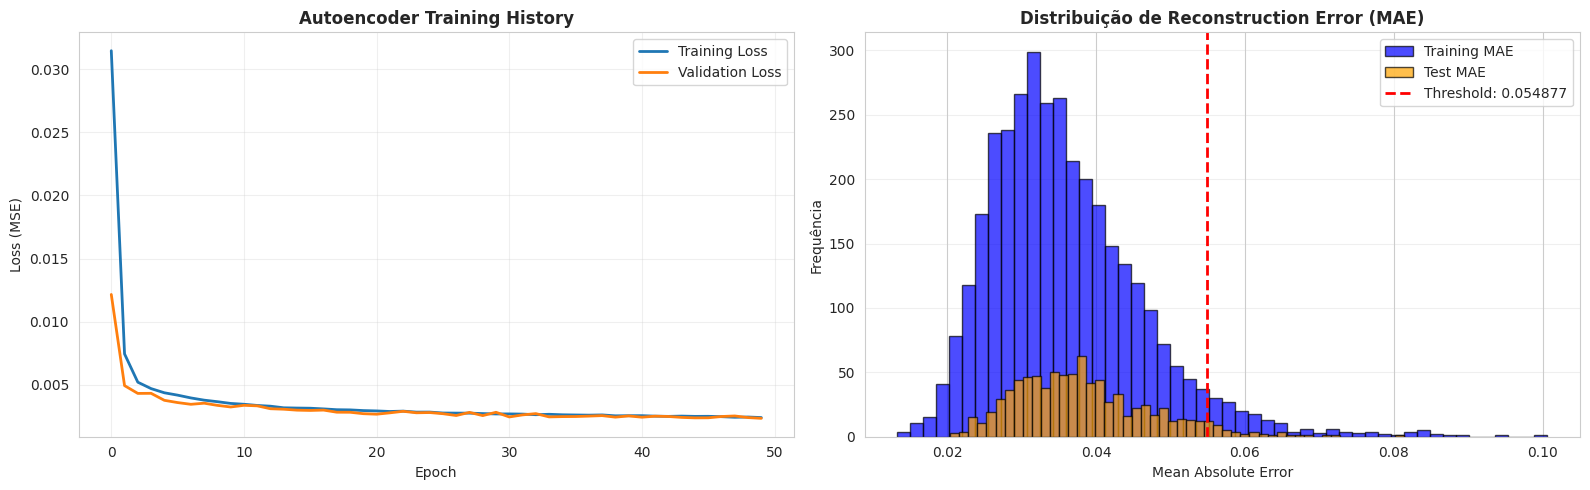

✓ Salvo: outputs/plots/04_autoencoder_anomalies.png


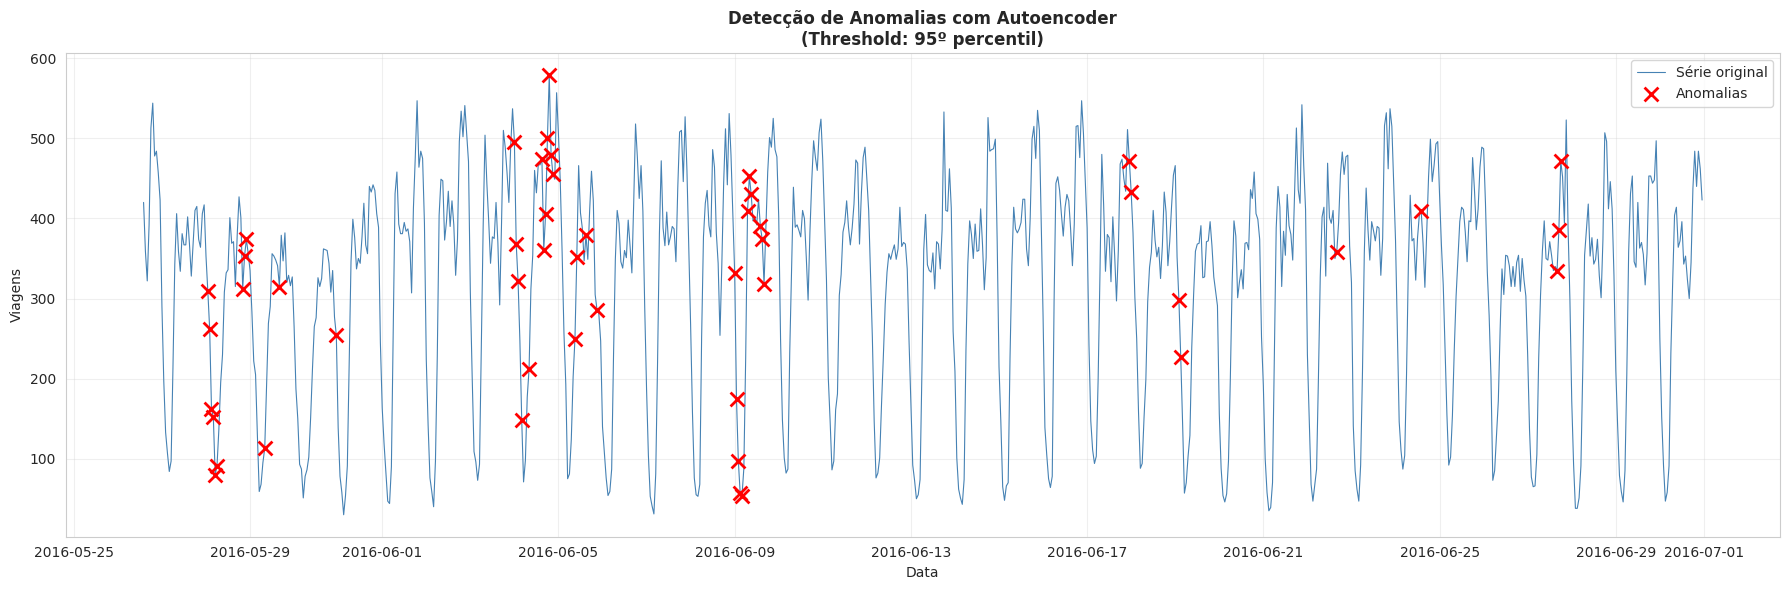

✓ Salvo: outputs/plots/04_reconstruction_error.png


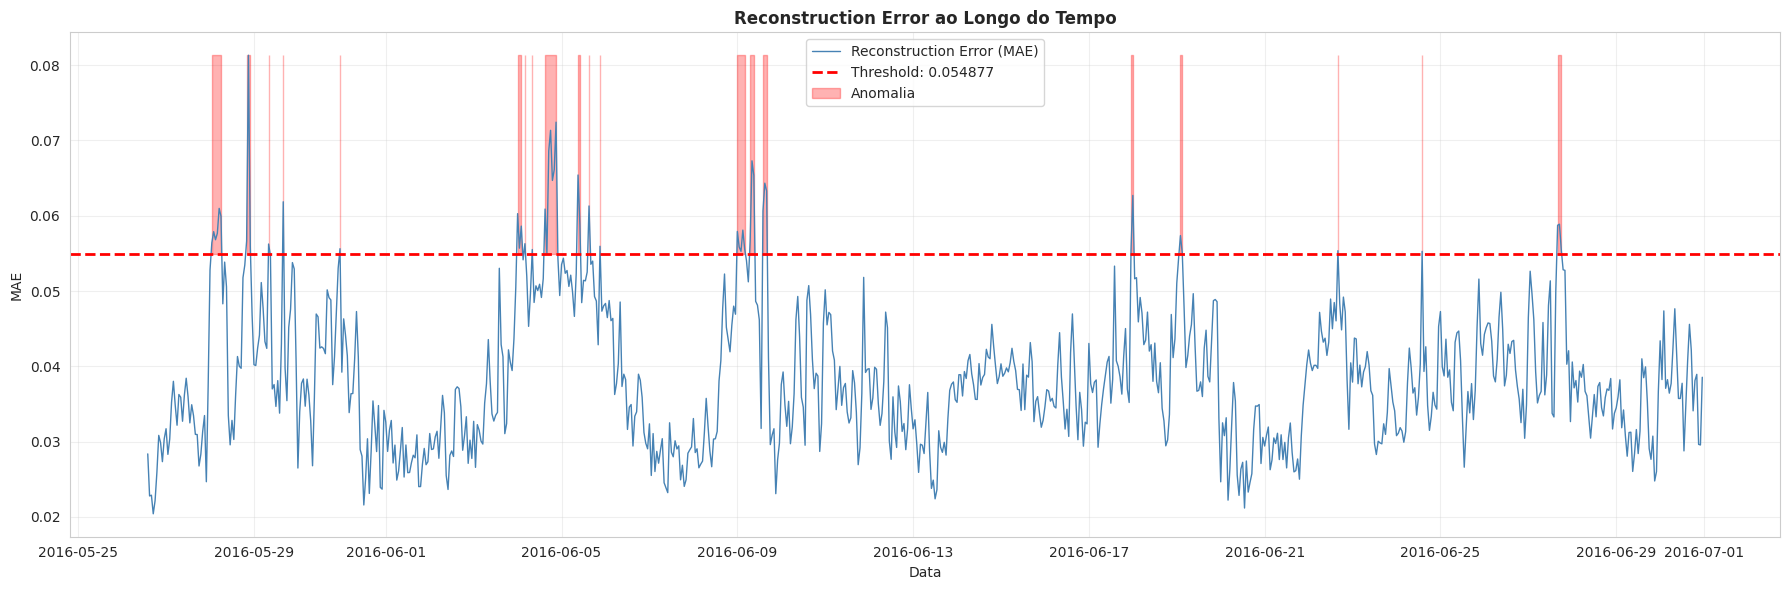

In [9]:
# ============================================================================
# VISUALIZAÇÕES
# ============================================================================

print("\n" + "=" * 70)
print("GERANDO VISUALIZAÇÕES")
print("=" * 70)

# Plot 1: Training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Autoencoder Training History', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribuição de erros
axes[1].hist(train_mae, bins=50, alpha=0.7, label='Training MAE', color='blue', edgecolor='black')
axes[1].hist(test_mae, bins=50, alpha=0.7, label='Test MAE', color='orange', edgecolor='black')
axes[1].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.6f}')
axes[1].set_title('Distribuição de Reconstruction Error (MAE)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Absolute Error')
axes[1].set_ylabel('Frequência')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/plots/04_autoencoder_training.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/04_autoencoder_training.png")
plt.show()

# Plot 2: Série temporal com anomalias
fig, ax = plt.subplots(figsize=(18, 6))

# Índices alinhados
test_aligned = test.iloc[seq_length:seq_length+len(test_predictions)].reset_index(drop=True)
anomaly_indices = np.where(test_predictions == 1)[0]
anomaly_times = test_aligned.iloc[anomaly_indices]

ax.plot(test_aligned['timestamp'], test_aligned['value'], 
       label='Série original', linewidth=0.8, color='steelblue')
ax.scatter(anomaly_times['timestamp'], anomaly_times['value'], 
          color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
ax.set_title('Detecção de Anomalias com Autoencoder\n(Threshold: 95º percentil)', 
            fontsize=12, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Viagens')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/04_autoencoder_anomalies.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/04_autoencoder_anomalies.png")
plt.show()

# Plot 3: Reconstruction error ao longo do tempo
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(test_aligned['timestamp'], test_mae, label='Reconstruction Error (MAE)', 
       linewidth=1, color='steelblue')
ax.axhline(threshold, color='red', linestyle='--', linewidth=2, 
          label=f'Threshold: {threshold:.6f}')
ax.fill_between(test_aligned['timestamp'], threshold, test_mae.max(), 
                where=(test_mae > threshold), alpha=0.3, color='red', label='Anomalia')
ax.set_title('Reconstruction Error ao Longo do Tempo', fontsize=12, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('MAE')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/04_reconstruction_error.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/04_reconstruction_error.png")
plt.show()

In [10]:
# ============================================================================
# SALVAR MODELO E RESULTADOS
# ============================================================================

print("\n" + "=" * 70)
print("SALVANDO MODELO E RESULTADOS")
print("=" * 70)

# Salvar modelo
autoencoder.save('outputs/models/autoencoder_day4.h5')
print("✓ Modelo salvo: outputs/models/autoencoder_day4.h5")

# Salvar resultados
results_df = test_aligned.copy()
results_df['reconstruction_error'] = test_mae
results_df['anomaly_pred'] = test_predictions
results_df['threshold'] = threshold

results_df.to_csv('outputs/reports/day4_autoencoder_results.csv', index=False)
print("✓ Resultados salvos: outputs/reports/day4_autoencoder_results.csv")



SALVANDO MODELO E RESULTADOS
✓ Modelo salvo: outputs/models/autoencoder_day4.h5
✓ Resultados salvos: outputs/reports/day4_autoencoder_results.csv


In [11]:
# ============================================================================
# ANÁLISE FINAL
# ============================================================================

print("\n" + "=" * 70)
print("ANÁLISE FINAL")
print("=" * 70)

print(f"\n📊 AUTOENCODER - RESUMO:")
print(f"  Arquitetura: Conv1D Encoder → Dense Latent → Conv1DTranspose Decoder")
print(f"  Latent dimension: {latent_dim}")
print(f"  Sequence length: {seq_length}")
print(f"  Epochs: 50")
print(f"  Loss: {history.history['loss'][-1]:.6f}")
print(f"  Validation Loss: {history.history['val_loss'][-1]:.6f}")

print(f"\n🎯 DETECÇÃO:")
print(f"  Threshold: {threshold:.6f} (95º percentil)")
print(f"  Anomalias detectadas: {n_anomalies} ({100*n_anomalies/len(test_predictions):.2f}%)")

print(f"\n💡 INTERPRETAÇÃO:")
print(f"  Reconstruction Error Alto = Anomalia")
print(f"  Reconstruction Error Baixo = Normal")
print(f"  O modelo aprendeu padrões normais e estranha o incomum")

print("\n" + "=" * 70)
print("DIA 4 CONCLUÍDO!")
print("=" * 70)
print("\nPróximos passos:")
print("  - Comparar com métodos dos dias anteriores")
print("  - Ajustar threshold ou latent_dim se necessário")
print("  - Dia 5: LSTM Autoencoder (melhor para séries temporais)")


ANÁLISE FINAL

📊 AUTOENCODER - RESUMO:
  Arquitetura: Conv1D Encoder → Dense Latent → Conv1DTranspose Decoder
  Latent dimension: 8
  Sequence length: 24
  Epochs: 50
  Loss: 0.002409
  Validation Loss: 0.002346

🎯 DETECÇÃO:
  Threshold: 0.054877 (95º percentil)
  Anomalias detectadas: 48 (5.65%)

💡 INTERPRETAÇÃO:
  Reconstruction Error Alto = Anomalia
  Reconstruction Error Baixo = Normal
  O modelo aprendeu padrões normais e estranha o incomum

DIA 4 CONCLUÍDO!

Próximos passos:
  - Comparar com métodos dos dias anteriores
  - Ajustar threshold ou latent_dim se necessário
  - Dia 5: LSTM Autoencoder (melhor para séries temporais)
